In [118]:
import pandas as pd
data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662_Project/Fire_Incidents_Data.csv')

/var/folders/46/jmhrztm12j78w43g2fnymb340000gn/T/ipykernel_12061/1231771012.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662_Project/Fire_Incidents_Data.csv')


# Data Cleaning

1. we need to do smth about missing values (this is what I did for now)

In [119]:
#drop all the columns that have 25% of its values missing except 'Estimated_Dollar_Loss'
threshold = 0.75 * len(data)
cols_to_drop = [col for col in data.columns if data[col].count() < threshold and col != 'Estimated_Dollar_Loss']
data_cleaned = data.drop(columns=cols_to_drop)

dropped_columns = set(data.columns) - set(data_cleaned.columns)
print(dropped_columns)

#now, drop rows that have any missing values
data = data_cleaned.dropna()

#drop _id cuz it's an identifier
data = data.drop(columns=['_id'])

{'Ext_agent_app_or_defer_time', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Possible_Cause', 'Fire_Alarm_System_Impact_on_Evacuation', 'Estimated_Number_Of_Persons_Displaced', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Status_of_Fire_On_Arrival', 'Area_of_Origin', 'Exposures', 'Material_First_Ignited', 'Sprinkler_System_Operation', 'Level_Of_Origin', 'Building_Status', 'Sprinkler_System_Presence', 'Fire_Alarm_System_Operation', 'Ignition_Source', 'Fire_Under_Control_Time', 'Smoke_Alarm_at_Fire_Origin', 'Business_Impact', 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 'Extent_Of_Fire', 'Fire_Alarm_System_Presence', 'Smoke_Spread', 'Method_Of_Fire_Control'}


2) we need to make sure all columns have proper datatypes

In [120]:
#convert the times into date.time objects
timestamp_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
data[timestamp_columns] = data[timestamp_columns].apply(pd.to_datetime, errors='coerce')

#make sure these columns have int objects
int_columns = [
    'Incident_Station_Area',
    'Civilian_Casualties',
    'Count_of_Persons_Rescued',
    'Incident_Ward',
    'Number_of_responding_apparatus',
    'TFS_Firefighter_Casualties'
]

for col in int_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

3. combing latitude & longitude into a single distance metric (euclidien distance)

In [121]:
data['Geo_Coordinate'] = (data['Latitude']**2 + data['Longitude']**2)**0.5
data = data.drop(columns=['Latitude', 'Longitude'])


4. we need to dummify all the categorical columns

In [122]:
categorical_columns = ['Final_Incident_Type', 'Property_Use', 'Initial_CAD_Event_Type']
data[categorical_columns] = data[categorical_columns].astype('category')

#check data types after cleaning and conversions
data.dtypes

Civilian_Casualties                        int64
Count_of_Persons_Rescued                   int64
Estimated_Dollar_Loss                    float64
Final_Incident_Type                     category
Incident_Number                           object
Incident_Station_Area                      int64
Incident_Ward                              int64
Initial_CAD_Event_Type                  category
Intersection                              object
Last_TFS_Unit_Clear_Time          datetime64[ns]
Number_of_responding_apparatus             int64
Number_of_responding_personnel           float64
Property_Use                            category
TFS_Alarm_Time                    datetime64[ns]
TFS_Arrival_Time                  datetime64[ns]
TFS_Firefighter_Casualties                 int64
Geo_Coordinate                           float64
dtype: object

# Linear Regression Assumptions Chekcings

multicolinearity between the predictors

                          Feature         VIF
0             Civilian_Casualties    1.106169
1        Count_of_Persons_Rescued    1.023740
2           Estimated_Dollar_Loss    1.172178
3           Incident_Station_Area    9.062693
4                   Incident_Ward    3.900539
5  Number_of_responding_apparatus  249.762680
6  Number_of_responding_personnel  266.312438
7      TFS_Firefighter_Casualties    1.085269
8                  Geo_Coordinate   16.931547


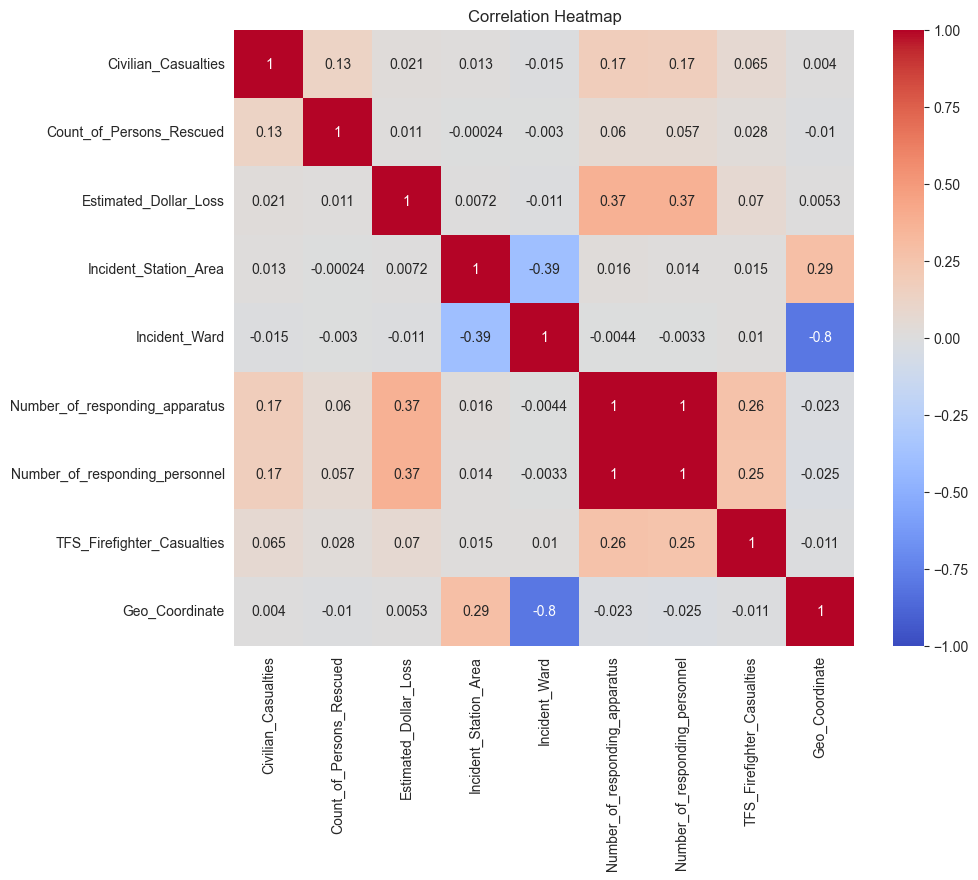

In [123]:
#to fix bug lol
import sys
sys.path.append('/opt/anaconda3/lib/python3.12/site-packages')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

#vif for each numerical prodictor
numerical_data = data.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_data.columns
vif_data['VIF'] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]

print(vif_data)

#correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [124]:
#let's drop 'Number_of_responding_apparatus' and 'Incident_Ward'
data = data.drop(columns=['Number_of_responding_apparatus', 'Incident_Ward'])

#vif for each numerical prodictor
numerical_data = data.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_data.columns
vif_data['VIF'] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]

print(vif_data)

                          Feature       VIF
0             Civilian_Casualties  1.100055
1        Count_of_Persons_Rescued  1.022896
2           Estimated_Dollar_Loss  1.171335
3           Incident_Station_Area  7.684244
4  Number_of_responding_personnel  2.592171
5      TFS_Firefighter_Casualties  1.082065
6                  Geo_Coordinate  8.798559


#  next we need to check the 4 foundamnetal assumptions of linear regression: normality, linearity, constant variance, and uncorrelated error. we also need to check influential points.
